In [1]:
# Import required libraries
import pathlib
import matplotlib as mpl
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.stats.proportion import proportion_confint
import matplotlib.patches as mpatches

# Enable inline plotting for matplotlib
%matplotlib inline


# Define default arguments for saving figures
savefig_args = {
    "dpi": 300,
    "bbox_inches": "tight",
    "pad_inches": 0.1,
    "transparent": True,
}

# Set Matplotlib savefig DPI
mpl.rc("savefig", dpi=300)

## OUTPUTS ## 
output_dir = "../figures/paper figures/EDFigure4/"
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)

# Define the subtype output directory and make sure it exists
subtypes = "../../data/annotation/subtypes"
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
# Define output file suffix and formats
output_suffix = ""
output_formats = [".png", ".pdf"]

# Function to save a figure in multiple formats
def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix,
                output_formats=output_formats, savefig_args=savefig_args):
    for output_format in output_formats:
        fig.savefig(
            f"{output_dir}/{name}{output_suffix}{output_format}", **savefig_args
        )
    return None

# Set Scanpy figure parameters
sc.set_figure_params(
    dpi_save=300, frameon=False,
    vector_friendly=True, fontsize=7, figsize=(3, 3),
    format='pdf', transparent=True
)

# Set Scanpy figure directory
sc.settings.figdir = output_dir
# Configure pandas display options
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 100)



# Import helper functions
%run ../scripts/global_plot_settings.py

# Set Seaborn style
sns.set_style("ticks")

# Use custom Matplotlib style
plt.style.use('../scripts/bursa.mplstyle')

CELLTYPE = "ASC"

In [2]:
adata = sc.read_h5ad(
    f"../../data/gex/{CELLTYPE}.h5ad.gz")

# Calculate Initial Representation

In [3]:
sc.pp.neighbors(adata, use_rep="X_scVI_all", n_neighbors=20)
sc.tl.umap(
    adata,
    min_dist=0.3,
)
sc.tl.leiden(adata, resolution = 1, key_added='leiden', n_iterations = 2)


/home/michaelswift/miniconda3/envs/bursa2ndary/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_19143/1257114380.py:6: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution = 1, key_added='leiden', n_iterations = 2)


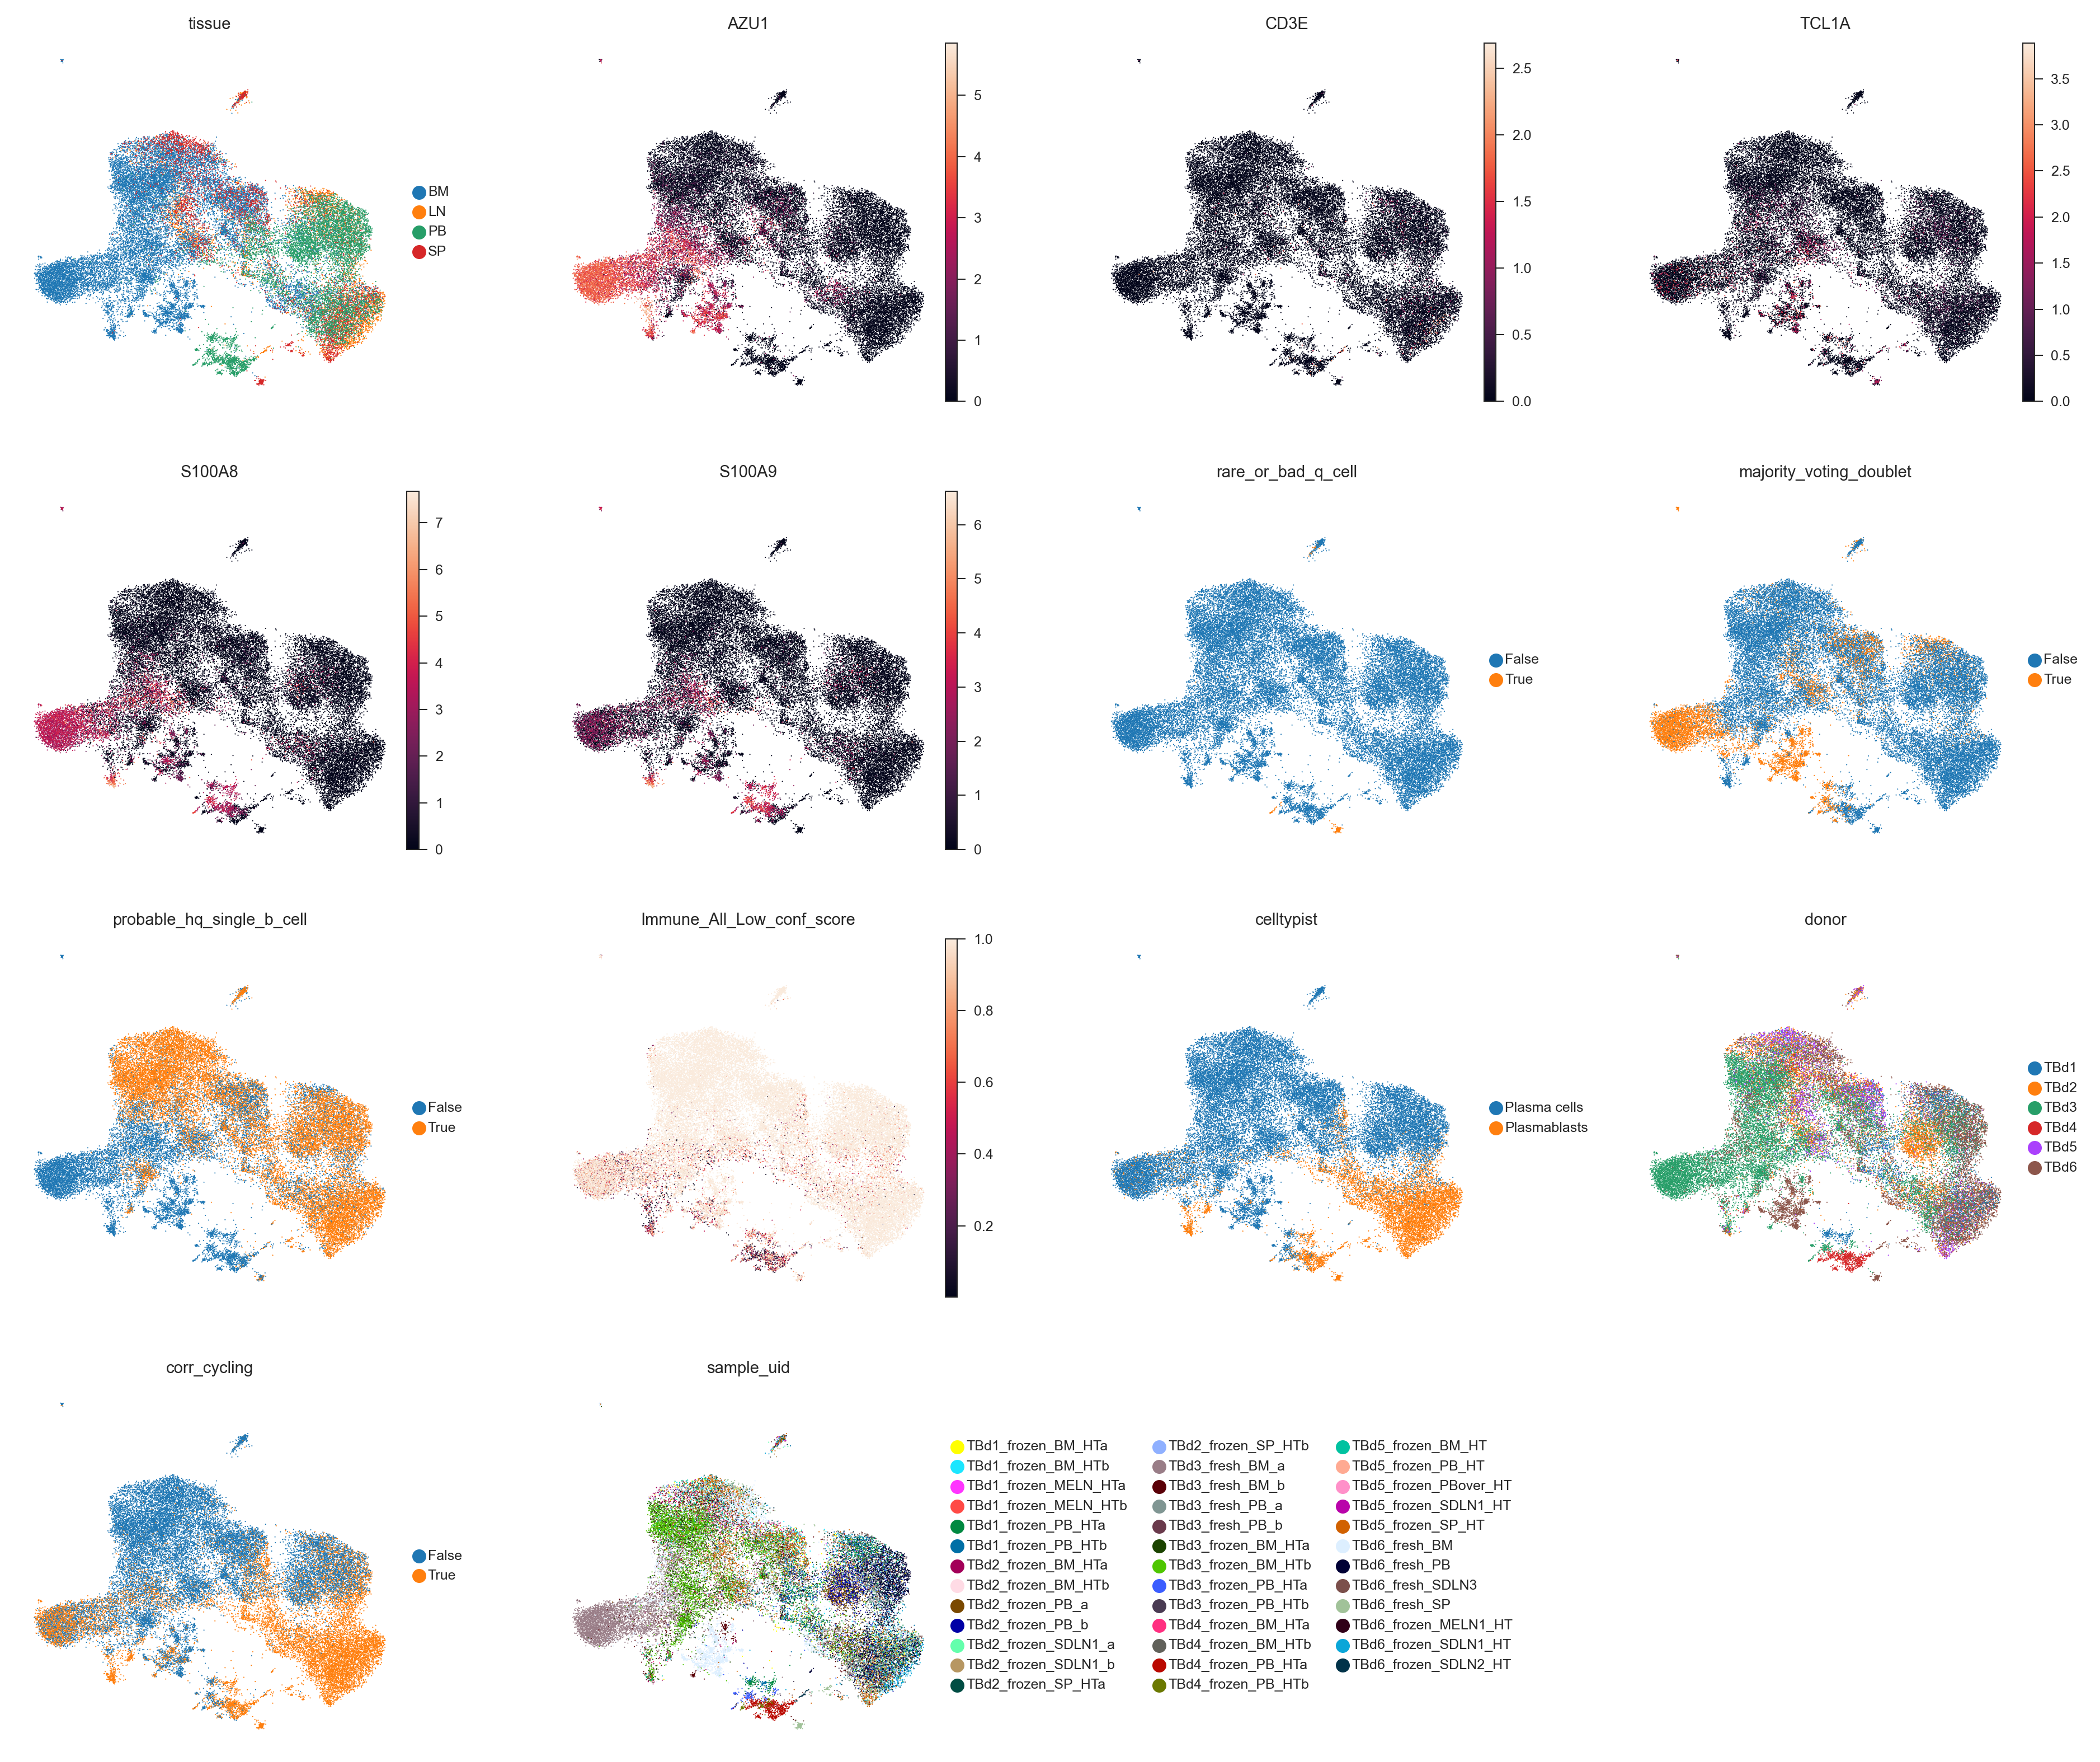

In [4]:
sc.pl.umap(adata, color = ['tissue', 'AZU1', 'CD3E', "TCL1A", "S100A8", "S100A9", 'rare_or_bad_q_cell', 
"majority_voting_doublet", 'probable_hq_single_b_cell', 
"Immune_All_Low_conf_score", 'celltypist', 'donor', 'corr_cycling', 'sample_uid', ], size = 1)

# remove contaminants and artifacts

In [5]:
# Subset to high quality single B cells
print(adata.shape[0], "possible ASCs by celltypist labeling")
adata = adata[adata.obs.probable_hq_single_b_cell == 'True']
print(adata.shape[0], "hq single ASCs via algorithmic flagging")

36955 possible ASCs by celltypist labeling
21192 hq single ASCs via algorithmic flagging


/home/michaelswift/miniconda3/envs/bursa2ndary/lib/python3.12/site-packages/scanpy/tools/_score_genes.py:176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(


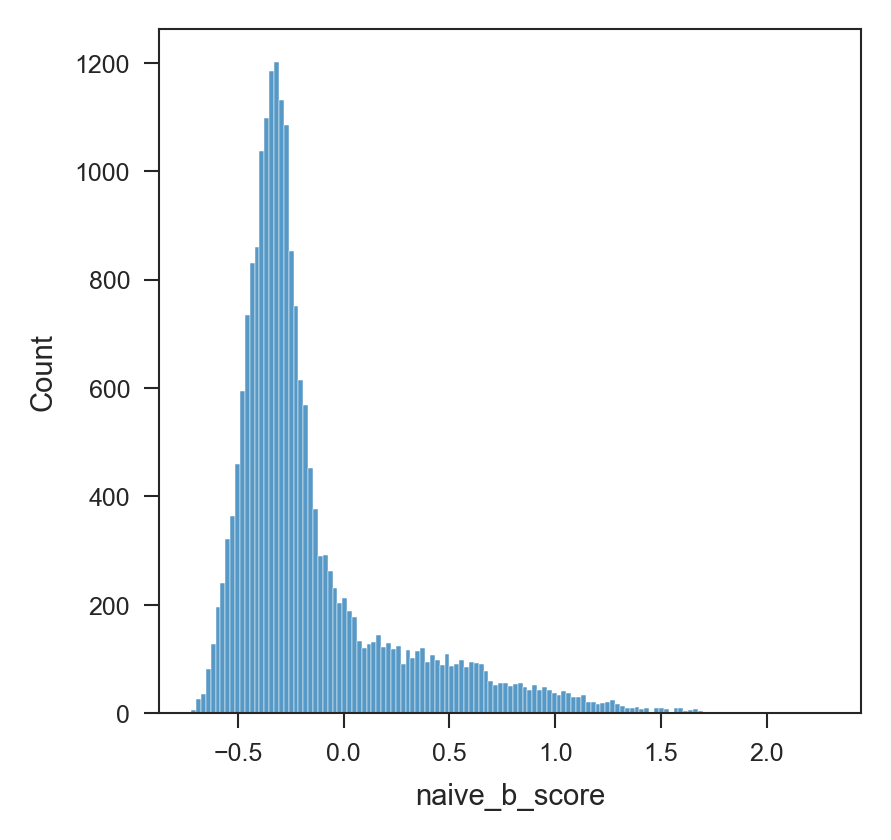

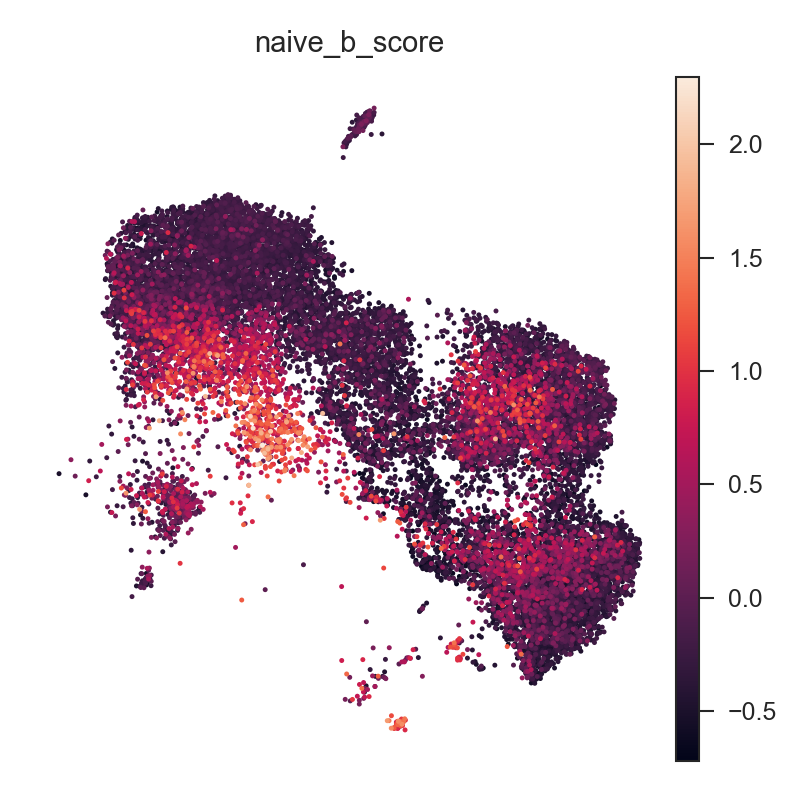

19284 ASCs after filtering out Naive ASC doublet signature
16024 ASCs after filtering out ASCs without a c_call (VDJ assembly)


In [6]:
# filter out known artefacts
sc.tl.score_genes(adata, gene_list = ['TCL1A', 'AFF3', "CD37", "BANK1"], score_name = "naive_b_score")
fig, ax = plt.subplots(1,1)
sns.histplot(data = adata.obs, x = 'naive_b_score', ax = ax)
sc.pl.umap(adata, color = 'naive_b_score')
# remove cells with high naive score
adata = adata[adata.obs.naive_b_score < 0.5]
print(adata.shape[0], "ASCs after filtering out Naive ASC doublet signature")
# remove cells without full VDJ assemblies 
adata = adata[adata.obs.c_call.isin(IGH_switched().keys())]
print(adata.shape[0], "ASCs after filtering out ASCs without a c_call (VDJ assembly)")

# Calculate new representation on filtered dataset

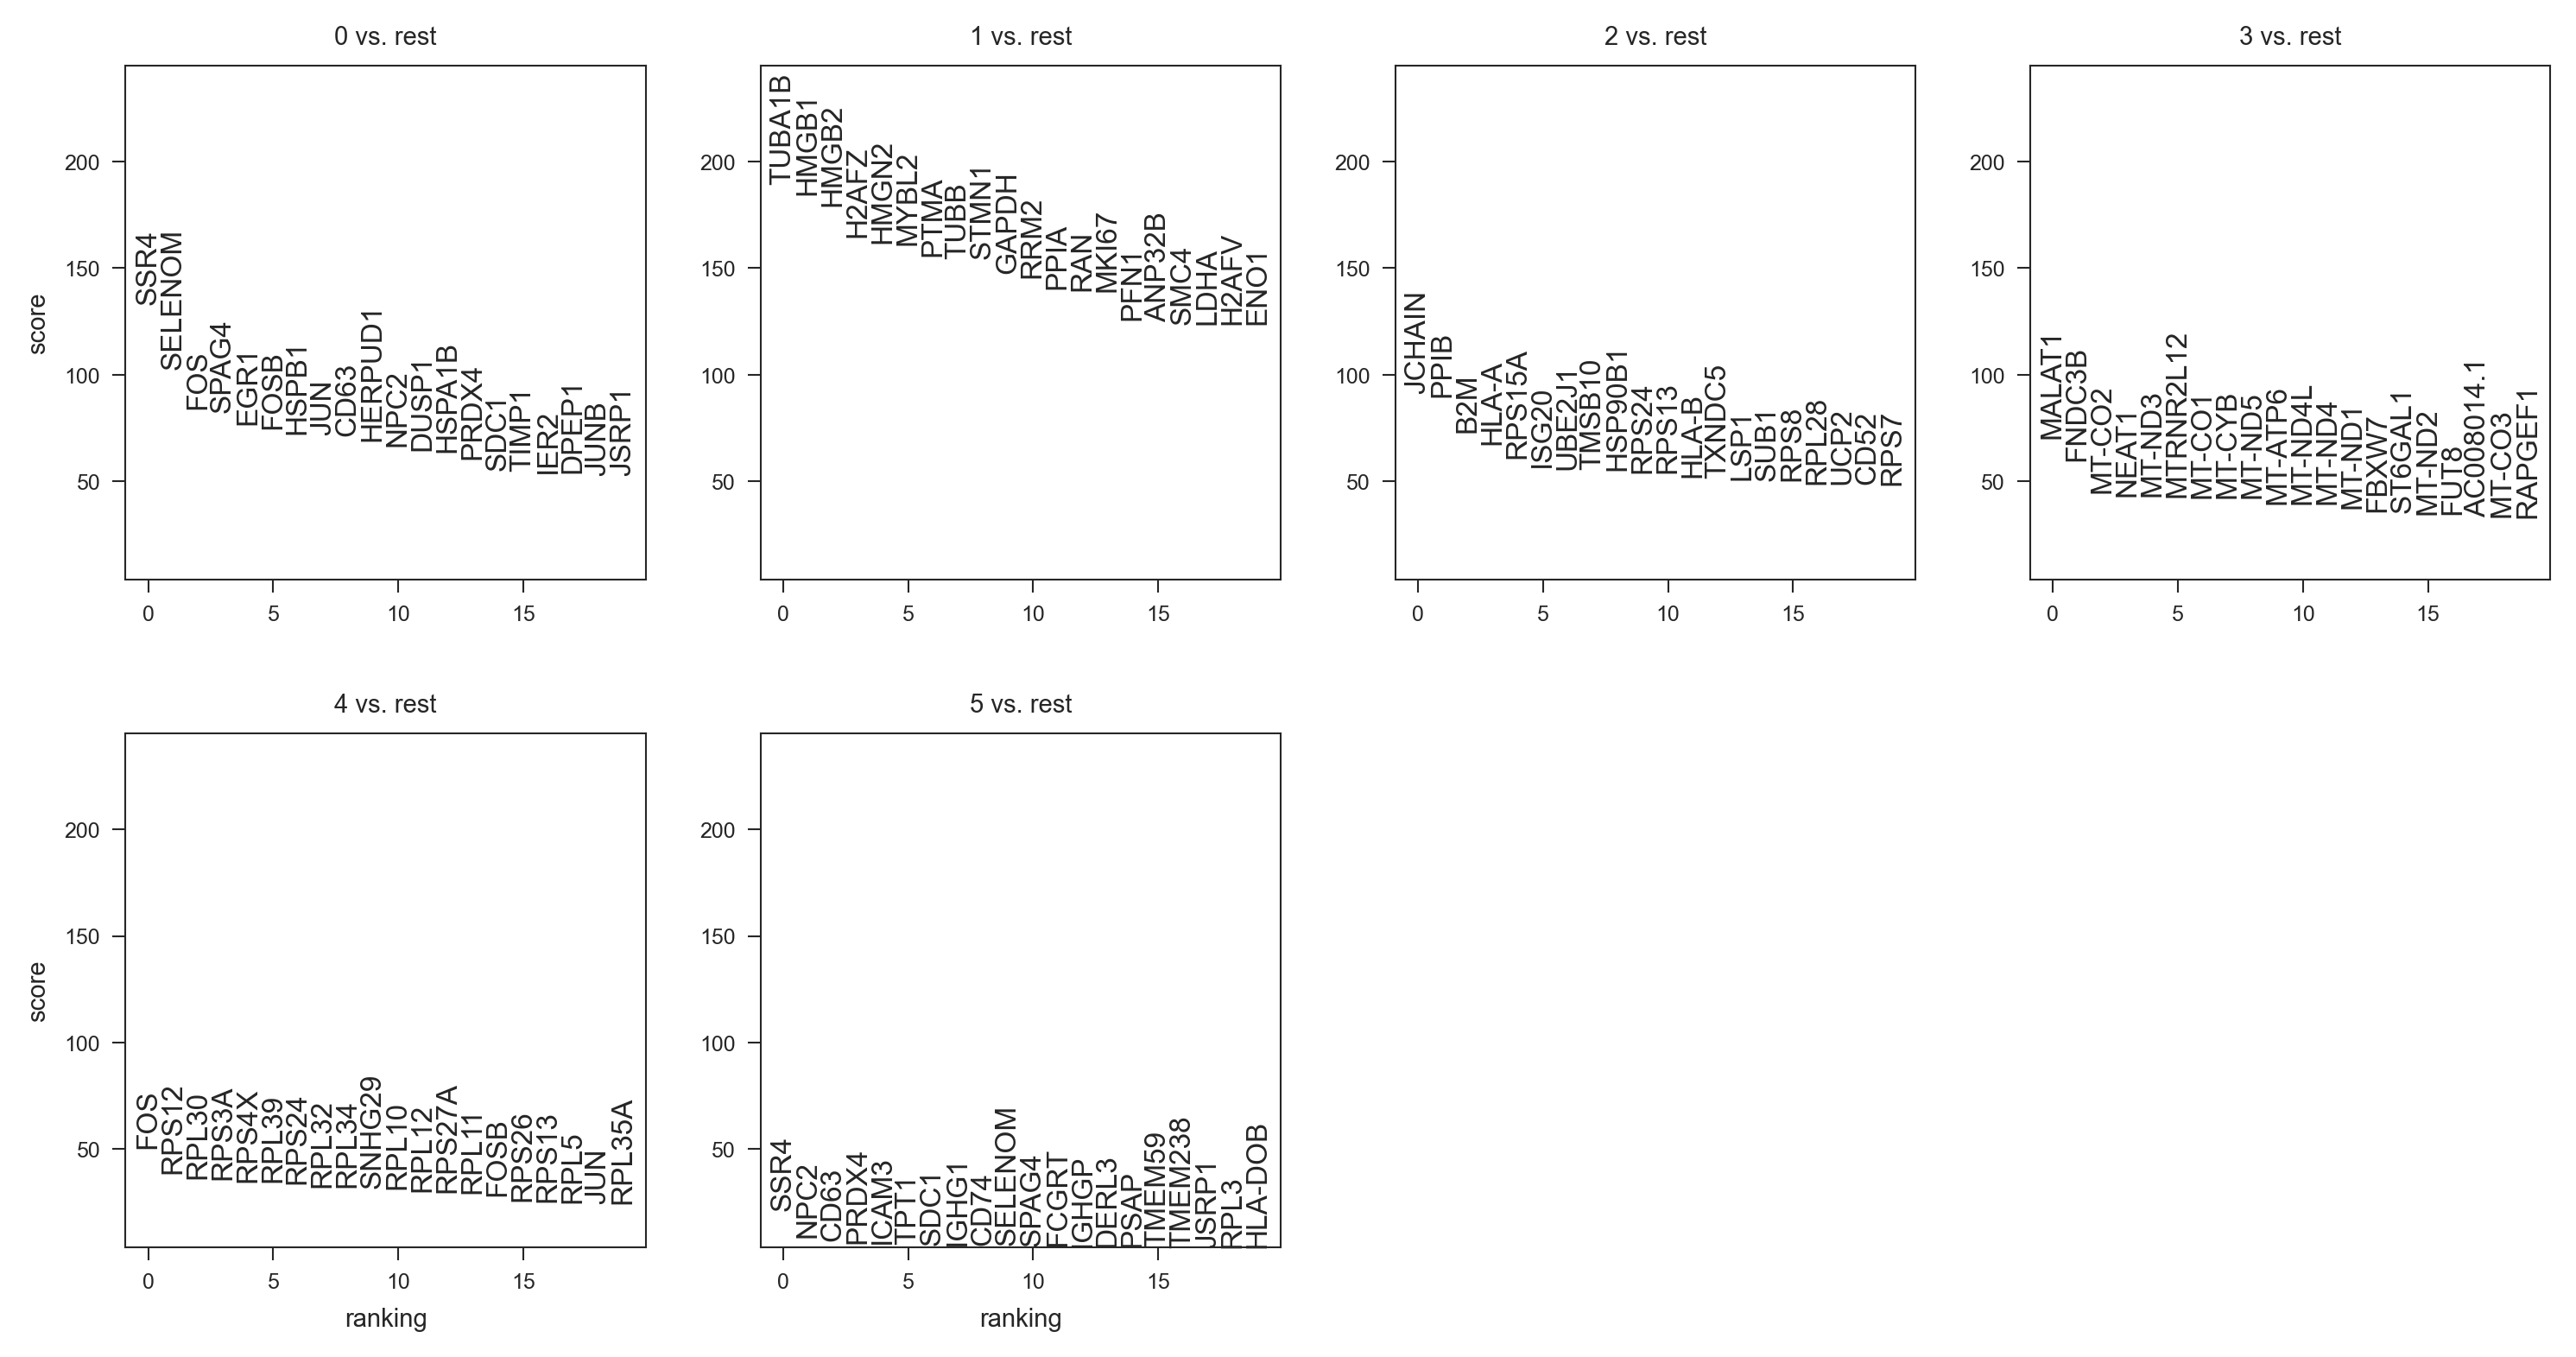

In [7]:
sc.pp.neighbors(adata, use_rep="X_scVI_all", n_neighbors=20)
sc.tl.umap(
    adata,
    min_dist=0.3,
)
sc.tl.leiden(adata, resolution=0.4)
sc.tl.rank_genes_groups(adata, groupby='leiden')
sc.pl.rank_genes_groups(adata)

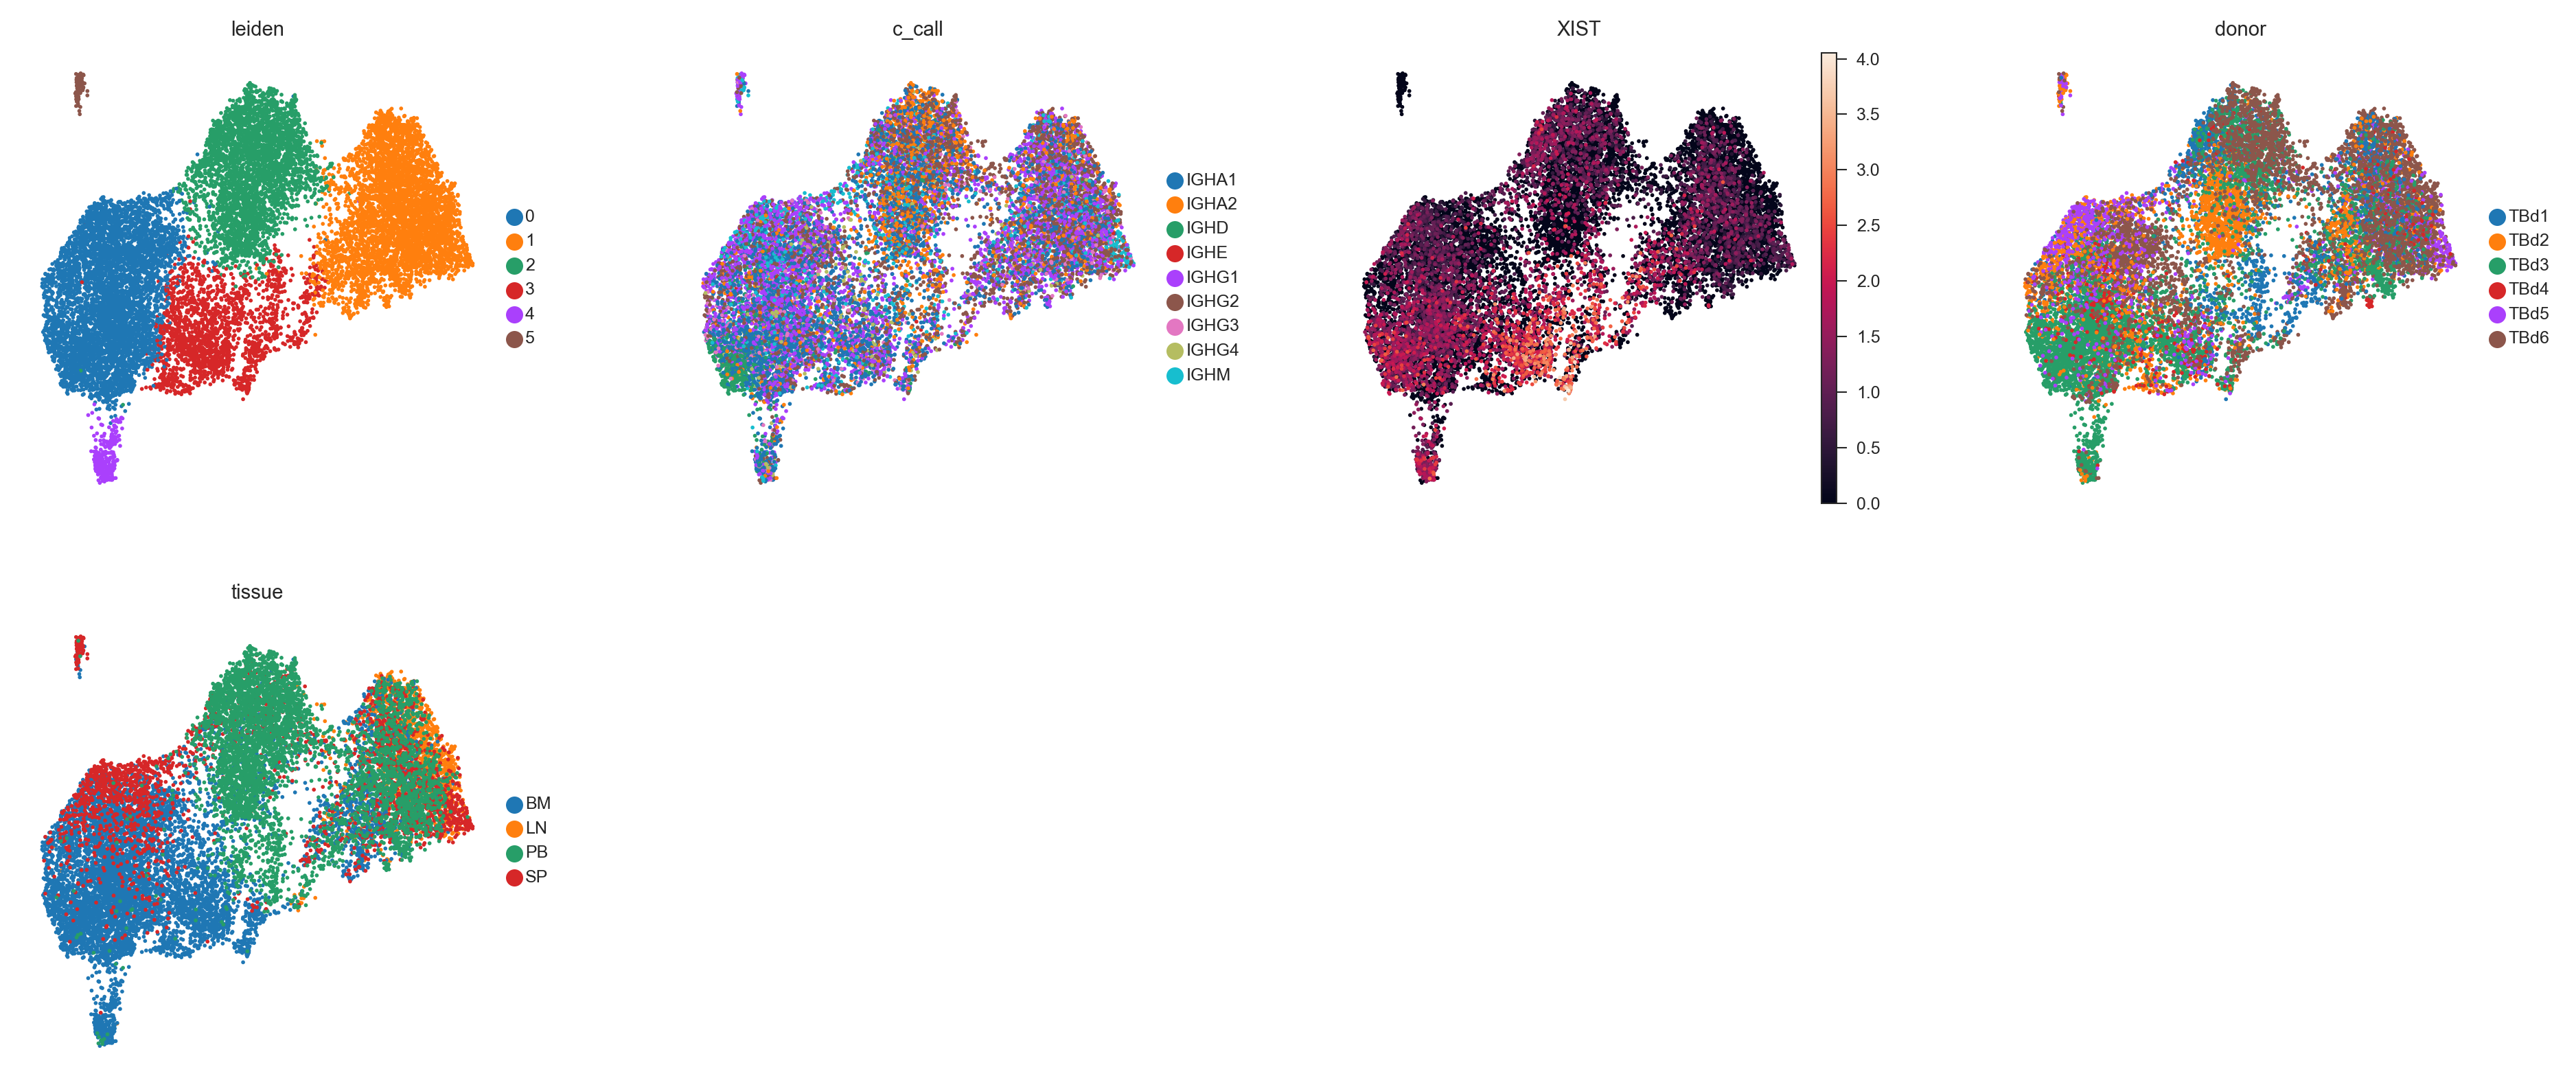

In [8]:
sc.pl.umap(adata, color = ['leiden', 'c_call', 'XIST', 'donor', 'tissue'])

## Manually annotate the subtypes


In [9]:

manual = {
    "0": f"{CELLTYPE}-1",
    "1": f"{CELLTYPE}-3",
    "2": f"{CELLTYPE}-3",
    "3": f"{CELLTYPE}-2",
    "4": f"{CELLTYPE}-1",
    "5": f"{CELLTYPE}-4"}
adata.obs["subtype"] = adata.obs.leiden.map(
    lambda x: manual.get(x, f"{CELLTYPE}")
)
adata.obs[['subtype']].to_csv(f"{subtypes}/ASC_subtypes.tab",sep = '\t')

# Generate and Save Figures

In [10]:
# change figure settings for saving figs
sc.set_figure_params(dpi_save=300, frameon=False,
 vector_friendly=True, fontsize=7, figsize=(1,1), format='pdf', transparent=True)

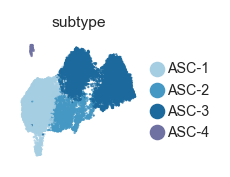

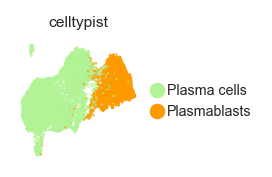

In [11]:
color = "subtype"
sc.pl.umap(adata, color = color, palette = get_colors('asc'), size = 4.5,
 alpha = 0.8, add_outline=False, save=f"{color}_{CELLTYPE}")


color = "celltypist"
sc.pl.umap(adata, color = color, palette = get_colors('bcelltype'), 
size = 4.5, alpha = 0.7, add_outline=False, save=f"{color}_{CELLTYPE}")


# color = "FCGRT"
# sc.pl.umap(adata, color = color,
# size = 4.5, alpha = 0.7, add_outline=False, save=f"{color}_{CELLTYPE}")

## Cell Cycle Regression

In [12]:
# show regression of Cell cycle signature
sc.pp.neighbors(adata, use_rep="scvi_cc_rep", n_neighbors=20, )
sc.tl.umap(
    adata,
    min_dist=0.3,
)

In [13]:
# change figure settings for inset regression figure
sc.set_figure_params(dpi_save=150, frameon=True,
 vector_friendly=True, fontsize=7, figsize=(0.8,0.8), format='pdf', transparent=True)

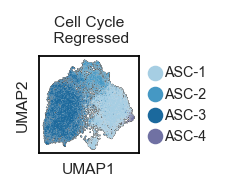

In [14]:
fig, ax = plt.subplots(1,1, figsize = (0.8,0.8))

color = "subtype"
sc.pl.umap(adata, color = color, palette = get_colors('asc'), size = 0.7, alpha = 0.7, add_outline=True, title = "Cell Cycle\n Regressed", ax = ax)

ax.spines[:].set_visible(True)
ax.legend([], frameon = False)
ax.set_xlabel("")
ax.set_ylabel("")

save_figure(fig, "umap_regressed_w_spines")

## Data Derived Markers

In [15]:
sc.tl.dendrogram(adata, groupby="subtype")
sc.tl.rank_genes_groups(adata, groupby="subtype")
sc.tl.filter_rank_genes_groups(
    adata, min_fold_change=1, min_in_group_fraction=0.2, max_out_group_fraction=0.6
)

In [16]:
# canonical markers
canonical_markers = ['SDC1', 'CD27', 'CD19', "CD38", "MS4A1", "CXCR4", 'MKI67', "HLA-DRB1"]
#transcriptional_markers = ["HLA-DOB", "CD9", "FCGRT", "LPP", "RASGEF1B", "PSME2", "ARHGDIB"]
# these are from SCVI-DE but you get a similar answer using less sophisticated tests
transcriptional_markers = ["TIMP1", "IFITM3", "FCGRT","RNF213", "SPAG4", "MYBL2", "ANKRD36C"]

markers =  canonical_markers + transcriptional_markers

## Gene Expression Markers for Subtypes

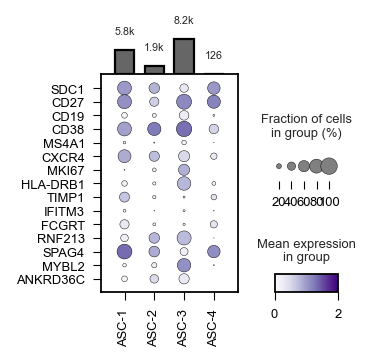

In [17]:
dp = sc.pl.DotPlot(adata, markers, groupby= 'subtype', figsize = (1.9, 2.2), vmax = 2, vmin = 0,  expression_cutoff = 0)
dp.legend(width=0.6)
dp.swap_axes()
dp.add_totals(color = '0.4', size = 0.5).style(dot_edge_color='black', largest_dot = 55 , dot_edge_lw=0.2, cmap = 'Purples').show()

### Tweak Figure

In [18]:
# get axes for tweaking out
#dp.legend(width=0.4)
axes = dp.get_axes()
# First, remove the current title
axes['size_legend_ax'].set_title("")
axes['size_legend_ax'].tick_params(axis='x', which = 'minor', length=0)
axes['size_legend_ax'].tick_params(axis='x', labelsize=5)
# Then, create a new title using a text object
title = "% cells\nexpression > 0"
axes['size_legend_ax'].text(0, 0.8, title, transform=axes['size_legend_ax'].transAxes, 
                            va='center', ha='left', fontsize = 6)


title = "Mean Expression\n($log_2$ UMI per 10K)"
axes['color_legend_ax'].set_title("")
axes['color_legend_ax'].text(0, 2.2, title, transform=axes['color_legend_ax'].transAxes, 
                            va='center', ha='left', fontsize = 6)
axes['color_legend_ax'].tick_params(axis='x', labelsize=5)

#axes['mainplot_ax'].spines[:].set_visible(True)
# Get the bounding box of the main plot
mainplot_box = axes['mainplot_ax'].get_position()
for bar in axes['group_extra_ax'].patches:
    bar.set_edgecolor('none')
ax = axes['mainplot_ax']
# add label
y_text_loc = ax.get_yticks()[(len(canonical_markers) - 2)]
x_text_loc = ax.get_xticks()[-1] + 1
ax.text(x_text_loc, y_text_loc, 'Canonical', rotation=90)
# add label
y_text_loc = ax.get_yticks()[13]
x_text_loc = ax.get_xticks()[-1] + 1
ax.text(x_text_loc, y_text_loc, 'Data-Derived', rotation=90)

dp.fig

save_figure(dp.fig, "dotplot_ascs")

# Cell Type Abundances

In [19]:
sns.set_style("ticks")
plt.style.use('../scripts/bursa.mplstyle')

In [20]:
# Relative Abundances of Plasma Cells in Tissues
def range_ci(x):
    return np.min(x), np.max(x)

df = adata.obs

# Subset the dataframe to include only subtypes with more than 20 cells
subtype_counts = df['subtype'].value_counts()
valid_subtypes = subtype_counts[subtype_counts > 20].index
df_subset = df[df['subtype'].isin(valid_subtypes)]

# Calculate fractions
data = (
    df_subset.groupby(["donor", "tissue"])
    .subtype.value_counts(normalize=True)
    .rename("fraction")
    .reset_index()
)

# Drop zeroes
data = data[data.fraction > 0]

# Drop TICA (keep only TBd donors)
data = data[data.donor.str.contains("TBd")]

/tmp/ipykernel_19143/1401630927.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_subset.groupby(["donor", "tissue"])


/home/michaelswift/miniconda3/envs/bursa2ndary/lib/python3.12/site-packages/seaborn/categorical.py:2761: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try pointplot
  warnings.warn(msg, UserWarning)
/tmp/ipykernel_19143/1430117141.py:1: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  g = sns.catplot(
/tmp/ipykernel_19143/1430117141.py:1: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  g = sns.catplot(
/tmp/ipykernel_19143/1430117141.py:1: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0.5}` instead.

  g = sns.catplot(


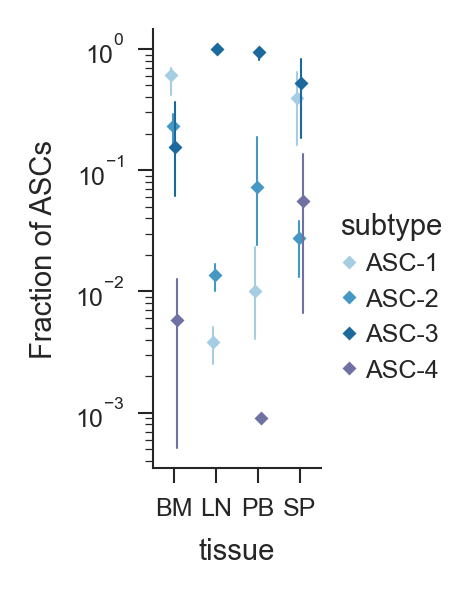

In [21]:
g = sns.catplot(
    data=data,
    x="tissue",
    y="fraction",
    hue="subtype",
    kind = 'point',
    join = False,
    errorbar = range_ci,
    dodge= 0.14,
    palette=get_colors('asc'),
    ax = ax,
    scale = 0.5, errwidth = 0.5, markers = 'D', height = 2, aspect = 0.6
)

g.set(yscale = 'log', ylabel = "Fraction of ASCs")
g.ax.tick_params(axis='x', which = 'minor', length=0)
sns.despine()

In [22]:
save_figure(g.figure, f"{CELLTYPE}_subtype_abundances_tissue")

fraction_fig = g.fig

# Isotype Usage of Distinct Subtypes

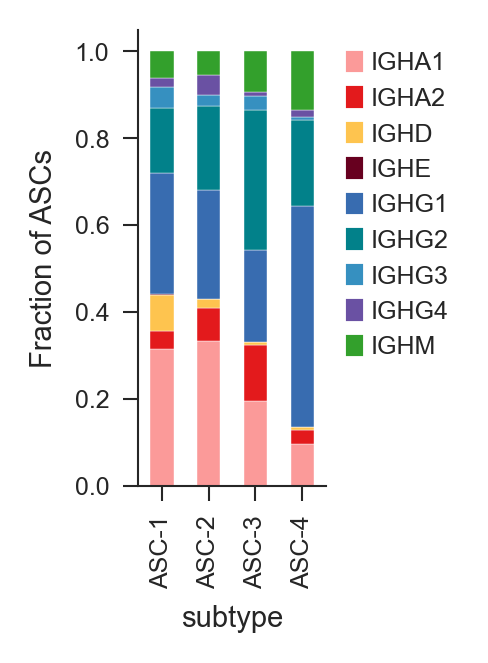

In [23]:
df = adata.obs
cross_tab = pd.crosstab(df['subtype'], df['c_call'], normalize='index')
fig, ax = plt.subplots(1,1, figsize = (0.8,2))

# Loop over each column (i.e., each stack in the bar)
for i, col in enumerate(cross_tab.columns):
    # Plot this column's data, specify color, add to existing plot (`bottom` parameter)
    cross_tab[col].plot(kind='bar', ax=ax, stacked=True, 
                        color=get_colors('IGH')[col], 
                        bottom = cross_tab.iloc[:, :i].sum(axis=1), linewidth = 0.1)


ax.tick_params(axis='x', which = 'minor', length=0)

# Create a list to store the patches for the legend
patches = []

# Loop over the colors used and create a patch for each
for col in cross_tab.columns:
    patches.append(mpatches.Patch(color=get_colors('IGH')[col], label=col))

# Create the legend
plt.legend(handles=patches, bbox_to_anchor=(1,1), frameon=False)
plt.xlabel('subtype')
plt.ylabel('Fraction of ASCs')
sns.despine()
save_figure(fig, f"_stackedbar_{CELLTYPE}_c_call")

## Cell Cycle

In [24]:
bcell_data = adata.obs
# Define the bin edges, stopping at 40
bin_edges = np.arange(0, 60, 4).tolist()  
#bin_edges.append(np.inf)  # Add a last bin for values greater than 40

# Define the labels for the bins, adding a label for the new bin
bin_labels = [0.0] + [round((bin_edges[i] + bin_edges[i + 1]) / 2, 1) for i in range(len(bin_edges) - 2)]
#bin_labels[-1] = '>40'  # Last label for the bin > 0.18

# Cut the data into bins with the new bin edges and labels
bcell_data.loc[:,'bin'] = pd.cut(bcell_data['v_mismatch'], bins=bin_edges, labels=bin_labels, include_lowest=True)

# Check the value counts for each bin
bcell_value_counts = bcell_data['bin'].value_counts()
print(bcell_value_counts, "number of B cells in each bin")
# Mapping dictionary
mapping_dict = {"Plasma cells": "ASCs", "Plasmablasts": "ASCs", "ASC-1": "ASCs", "ASC-2": "ASCs", "ASC-3":"ASCs", "ASC-4":"ASCs"}

# Group by 'bin' and 'tissue'
grouped = bcell_data.groupby(['bin', "subtype"])

# Calculate the fraction of cells that are cycling and the confidence intervals for each group
def calculate_fraction_and_ci(group, method='beta'):
    count = (group['cycling'] == "True").sum()
    n_total = len(group)
    fraction = count / n_total
    lower, upper = proportion_confint(count, n_total, alpha=0.05, method = method)
    return pd.Series({'fraction_cycling': fraction, 'lower_ci': lower, 'upper_ci': upper})

cycling_fractions_per_tissue = grouped.apply(calculate_fraction_and_ci).reset_index()

cycling_fractions_per_tissue = cycling_fractions_per_tissue.dropna()

bin
14.0    2362
18.0    2300
22.0    1855
10.0    1761
26.0    1563
6.0     1452
30.0    1116
2.0      772
34.0     751
0.0      601
38.0     542
42.0     325
46.0     227
50.0     132
Name: count, dtype: int64 number of B cells in each bin


/tmp/ipykernel_19143/78072191.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = bcell_data.groupby(['bin', "subtype"])
/tmp/ipykernel_19143/78072191.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cycling_fractions_per_tissue = grouped.apply(calculate_fraction_and_ci).reset_index()


In [25]:
# Calculate sample sizes
bcell_data['sample_size'] = bcell_data.groupby('sample_uid')['sample_uid'].transform('size')

# Filter samples with more than 30 cells
filtered_data = bcell_data[bcell_data['sample_size'] > 30]

# Calculate group sizes for subtype + sample_uid combinations
group_sizes = filtered_data.groupby(['subtype', 'sample_uid']).size().reset_index(name='group_size')

# Filter groups with more than 10 members
valid_groups = group_sizes[group_sizes['group_size'] > 10]

# Merge valid groups back to filtered_data
filtered_data = filtered_data.merge(valid_groups[['subtype', 'sample_uid']], on=['subtype', 'sample_uid'])

# Calculate the fraction of cycling cells for each subtype and sample
cycling_fractions = filtered_data.groupby(['subtype', 'sample_uid'])['cycling'].apply(
    lambda x: (x == "True").mean()
).reset_index(name='fraction_cycling')

# Keep only the rows where cycling is True (which is now represented by fraction_cycling > 0)
cycling_fractions = cycling_fractions[cycling_fractions['fraction_cycling'] > 0]

/tmp/ipykernel_19143/1669154155.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bcell_data['sample_size'] = bcell_data.groupby('sample_uid')['sample_uid'].transform('size')
/tmp/ipykernel_19143/1669154155.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_sizes = filtered_data.groupby(['subtype', 'sample_uid']).size().reset_index(name='group_size')
/tmp/ipykernel_19143/1669154155.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and s

In [26]:
mapper = dict(zip(bcell_data["sample_uid"], bcell_data['tissue']))

In [27]:
cycling_fractions.loc[:,'tissue'] = cycling_fractions['sample_uid'].map(mapper)

/home/michaelswift/miniconda3/envs/bursa2ndary/lib/python3.12/site-packages/seaborn/categorical.py:2761: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try pointplot
  warnings.warn(msg, UserWarning)
/tmp/ipykernel_19143/1734198042.py:1: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  g = sns.catplot(
/tmp/ipykernel_19143/1734198042.py:1: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  g = sns.catplot(
/tmp/ipykernel_19143/1734198042.py:1: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0.5}` instead.

  g = sns.catplot(


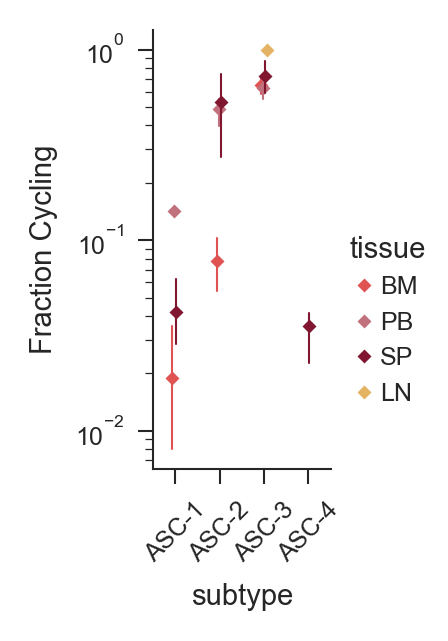

In [28]:
g = sns.catplot(
    data=cycling_fractions,
    x="subtype",
    y="fraction_cycling",
    hue="tissue",
    kind = 'point',
    join = False,
    dodge= 0.14,
    palette=get_colors('tissue'),
    ax = ax,
    scale = 0.5, errwidth = 0.5, markers = 'D', height = 2, aspect = 0.6
)

g.set(yscale = 'log', ylabel = "Fraction Cycling")
g.ax.tick_params(axis='x', which = 'minor', length=0)
plt.xticks(rotation=45)

sns.despine()

g.savefig(f"{output_dir}/cycling_fraction_per_tissue.pdf")

# Distribution of Mutation levels for different subtypes

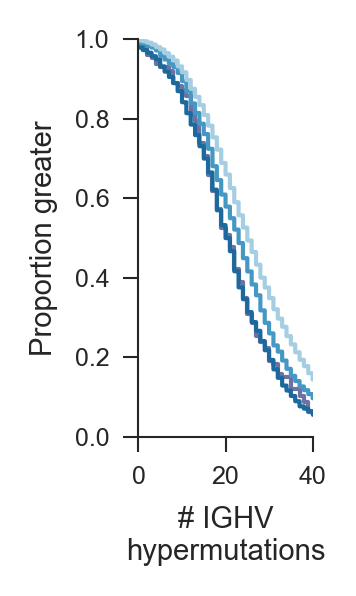

In [29]:
df = adata.obs
g = sns.displot(data = df, x="v_mismatch", hue = "subtype",
                 kind = 'ecdf', complementary = True, palette = get_colors('asc'), legend = False, height = 2, aspect = 0.6)
g.set(xlim=(0,40), xlabel = "# IGHV\nhypermutations", ylabel = "Proportion greater") 
plt.tight_layout()
save_figure(g.figure, f"ecdf_{CELLTYPE}")